In [5]:
 # Some general imports
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np

# Dummy text: uncomment next line if you need to
#!pip install lorem
import lorem

# Custom code (see ngram_lm.py, rnn_lm.py and utils.py)
from ngram_lm import ngrams, UnsmoothedLM, characters_from_files, words_from_files
from rnn_lm import get_next_probability, generate_text, stepwise_scores
from utils import plot_output


# Probabilistic Text Generator


Define a probabilistic model of sentences based on the chain rule of probabilities.

$$P(The, cat, sat, on, the, mat, .) = $$


$$P(The | \text{<}bos\text{>}) *$$


$$ P(cat | \text{<}bos\text{>} , The) * $$ 


$$ \ldots$$


$$ P(. | \text{<}bos\text{>} , \ldots , mat)$$

# How do we generate text from a probabilistic model of sentences?

$$w_1 \sim P(w|\text{<}bos\text{>})$$

$$w_2 \sim P(w|\text{<}bos\text{>}, w_1)$$

$$\ldots$$

$$w_n \sim P(w|\text{<}bos\text{>}, w_1, ..., w_{n-1})$$

# Ngram-based (unsmoothed) Language Model

- Straight-forward way of implementing a *probabilistic text generator*
- A Language Model that estimates the output probability distribution on the basis of n-gram statistics
- (ref. Y. Goldberg's http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139)



## How to fit the model:

- Compute ngrams
- Count number of times each ngram appears in front of each vocabulary item
- Normalize into probabilities

In [ ]:
# Before we continue, let's grab some Lorem Ipsum text to get going

sent = lorem.sentence()
print(sent)

## Get some training text
corpus = [c for _ in range(1000) for c in lorem.sentence()]

## Alternatively uncomment this block to get some real shakespeare data
# !wget http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
# with open('data/shakespeare_input.txt', 'r') as f:
#     corpus = [c for sent in f for c in sent]

### Compute n-grams

In [ ]:
# `ngram`: function defined in ngram_lm.py that computes ngrams over input sequences
for i in ngrams(sent[:10], 3):
    print(i)

### Count prefix/target co-occurrences and normalize into probabilities

In [4]:
model = defaultdict(Counter)

# count prefix/target co-occurrences
for ngram in ngrams(corpus, 5): 
    # use first n-1 characters as prefix, last character as target
    *prefix, target = ngram
    model[tuple(prefix)][target] += 1 # accumulate counts
    
# normalize into probability distribution
for prefix, counter in model.items():
    total = sum(counter.values())
    model[prefix] = [(target, counts/total) for target, counts in counter.items()]

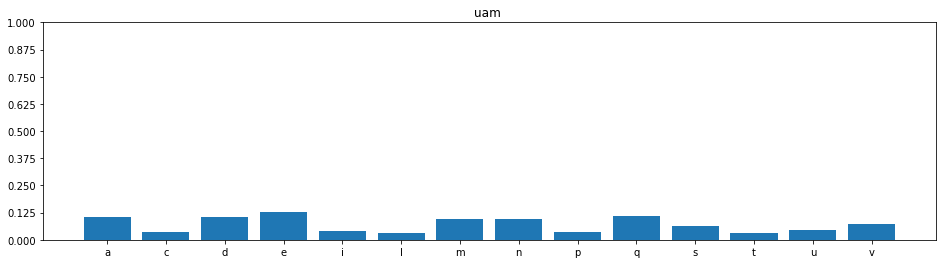

In [5]:
# Visualize output distribution by querying the model and displaying output probability distribution

# random ngram from the corpus
prefix = 'uam ' 
targets, probs = zip(*model[tuple(prefix)])
# function from utils.py to plot an output distribution
plot_output(targets, probs, prefix)

# RNN-based Language Model

- Exploit RNN capability to model forward information flow to condition the output probability on theoretically all previous steps
- While ngram model is limited in scope by the "markov" assumption that any character is only conditioned by the previous n characters, an RNN-based model is able to capture much longer dependencies

In [6]:
from IPython.display import SVG, display
display(SVG('./img/rnnlm.svg'))

In [3]:
# `seqmod` is our custom library to train RNN-based models
# To run this cell you'll need to make sure you have it
#   1. clone or download the package from "https://github.com/emanjavacas/seqmod"
#   2. put it on your python path
#       import sys; sys.append("/path/to/seqmod/")
from seqmod.utils import load_model

rnnlm = load_model('models/shakespeare-1.8850.pt')
print(rnnlm)

LM(
  (embeddings): Embedding(68, 100)
  (rnn): LSTM(100, 1000, num_layers=2, dropout=0.5)
  (project): FullSoftmax(
    (output_emb): Linear(in_features=1000, out_features=68, bias=True)
  )
)


/home/manjavacas/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'seqmod.modules.lm.LM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


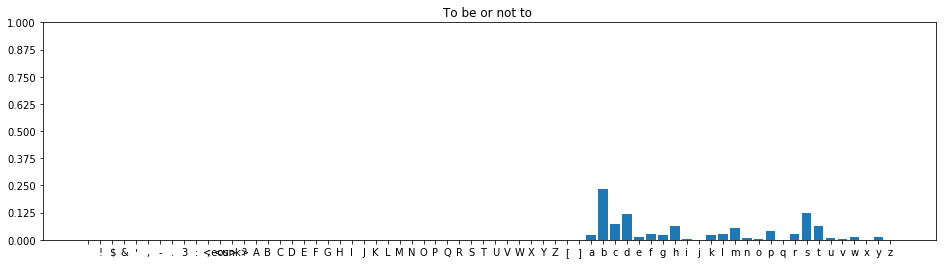

In [9]:
prefix = 'To be or not to '
targets, probs = get_next_probability(rnnlm, prefix) # function from rnn_lm.py to extract the output distribution
plot_output(targets, probs, prefix)

# Temperature: tweaking the output distribution to enforce/penalize diversity

- Generated text can often be boring, dull but also too non-sensical
- We can tweak diversity by boosting or reducing model's confidence
- This is achieve by artifically skewing or flattening the output distribution

Given the model output at a given step:

$$p=P(w|The,cat,sat,on,the)$$ 

where p is a probability distribution over the vocabulary: 

$$p = \{p_1, p_2, ..., p_v\}$$


Define the transformed probability distribution by applying an element-wise non-linear function depending on user-defined parameter $\tau$ (usually in range 0-2):

$$p^{\prime}_i = p_i^{(1/\tau)}$$

and renormalizing into a probability distribution by softmax:

$$p^{\tau}_i = \frac{p_i^{\prime}}{\sum_{j=1}^v p_j^{\prime}}$$


### Visualizing the effect of temperature

In [22]:
# fit a model on shakespeare data (rnnlm model is trained on same dataset)
# UnsmoothedLM is defined in ngram_lm.py
lm = UnsmoothedLM(4).fit(characters_from_files('./data/shakespeare_input.txt'))

# auxiliary functions to query the ngram model
def query_lm(model=lm, seed='irst'):
    """Query a random probability from the NGRAM lm model"""
    targets, probs = zip(*model.model[tuple(seed)])
    probs = np.array(probs)
    return targets, probs, seed

# auxiliary function to query the rnn model
def query_rnnlm(model=rnnlm, seed='Hi there '):
    targets, probs = get_next_probability(rnnlm, seed)
    return targets, probs, seed

# some imports for interactive viz
from ipywidgets import interact, ToggleButton

In [ ]:
targets, probs, prefix = query_lm(seed="irst")

def plot(temperature=1.0):
    # sort alphabetically
    xticks, y = zip(*sorted(zip(targets, probs), key=lambda t: t[0]))
    x = np.arange(len(targets))
    fig = plt.figure(figsize=(16, 4))
    plt.bar(x, lm.apply_temperature(np.array(y), temperature))
    plt.title(''.join(prefix))
    plt.xticks(x, xticks)
    plt.yticks(np.linspace(0, 1, 9))
    plt.show()

interact(plot, temperature=(1e-2, 3))

In [ ]:
targets, probs, prefix = query_rnnlm(seed="To be or not to ")

def plot(temperature=1.0):
    # sort alphabetically
    xticks, y = zip(*sorted(zip(targets, probs), key=lambda t: t[0]))
    x = np.arange(len(targets))
    fig = plt.figure(figsize=(16, 4))
    plt.bar(x, lm.apply_temperature(np.array(y), temperature))
    plt.title(''.join(prefix))
    plt.xticks(x, xticks)
    plt.yticks(np.linspace(0, 1, 9))
    plt.show()

interact(plot, temperature=(1e-2, 3))

# Visualizing model certainty while processing text

We are using code inside `./viz/` which is based on code by @karpathy (http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

To run the following visualization you first have to go into `./viz/` and run `python server.py`.

In [19]:
from viz.client import register_data # function to compute per-charater scores and send them to the viz server

# some random text by Shakespeare
text = """We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge."""

In [ ]:
targets, scores = stepwise_scores(rnnlm, text, score_entropy=False)
register_data(targets, scores)